# Prediccion Tráfico de Bicicletas usando DL/LSTM
UDD - MDS18 - DL<br>
Trabajo Final Deep Learning
- Alumno: Marcelo Rovai
- Profesor: Pablo Figueroa
- Santiago, 26/12/19

## Libraries & Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

Using TensorFlow backend.


In [2]:
import itertools
from scipy import stats
import statsmodels.api as sm
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from fbprophet import Prophet

In [76]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
pd.plotting.register_matplotlib_converters()

## Funciones Generales

In [4]:
def decomp_data(y, x_size = 15, y_size=7):    
    rcParams['figure.figsize'] = x_size, y_size
    decomposition = sm.tsa.seasonal_decompose(y, freq=365, model='additive')
    fig = decomposition.plot()
    plt.show()

In [118]:
def graficar_predicciones(real, prediccion, titulo='Previsión versus datos reales'):
    plt.subplots(figsize=(16,8))
    plt.plot(real[0:len(prediccion)],color='red', label='Dato Real')
    plt.plot(prediccion, color='blue', label='Predicción')
    #plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Dias')
    plt.ylabel('Numero de ciclistas')
    plt.legend()
    plt.title(titulo);

In [6]:
def metric_prophet(df, forecast):

    metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True)
    
    y_true, y_pred = np.array(metric_df.y), np.array(metric_df.yhat)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(metric_df.y, metric_df.yhat)
    mse = mean_squared_error(metric_df.y, metric_df.yhat)
    rmse = np.sqrt(mean_squared_error(metric_df.y, metric_df.yhat))
    mae = mean_absolute_error(metric_df.y, metric_df.yhat)

    print ('R2 =', round(r2, 2))
    print ('MSE =', round(mse, 2))
    print ('RMSE =', round(rmse, 2)) 
    print ('MAE =', round(mae, 2))
    print ('MAPE =', round(mape, 2))
    
    return r2, mse, rmse, mae, mape 

## Bajando la Data

Fremont Bridge - Seattle, US<br>
https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

In [8]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1956k    0 1956k    0     0   565k      0 --:--:--  0:00:03 --:--:--  565k


In [27]:
df = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
df.shape

(62760, 3)

In [28]:
df.head()

Fremont Bridge Total  Fremont Bridge East Sidewalk  \
Date                                                                      
2012-10-03 00:00:00                  13.0                           4.0   
2012-10-03 01:00:00                  10.0                           4.0   
2012-10-03 02:00:00                   2.0                           1.0   
2012-10-03 03:00:00                   5.0                           2.0   
2012-10-03 04:00:00                   7.0                           6.0   

                     Fremont Bridge West Sidewalk  
Date                                               
2012-10-03 00:00:00                           9.0  
2012-10-03 01:00:00                           6.0  
2012-10-03 02:00:00                           1.0  
2012-10-03 03:00:00                           3.0  
2012-10-03 04:00:00                           1.0

In [32]:
df.isnull().sum()

Fremont Bridge Total            10
Fremont Bridge East Sidewalk    10
Fremont Bridge West Sidewalk    10
dtype: int64

In [33]:
df = df.dropna()

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62750 entries, 2012-10-03 00:00:00 to 2019-11-30 23:00:00
Data columns (total 3 columns):
Fremont Bridge Total            62750 non-null float64
Fremont Bridge East Sidewalk    62750 non-null float64
Fremont Bridge West Sidewalk    62750 non-null float64
dtypes: float64(3)
memory usage: 1.9 MB


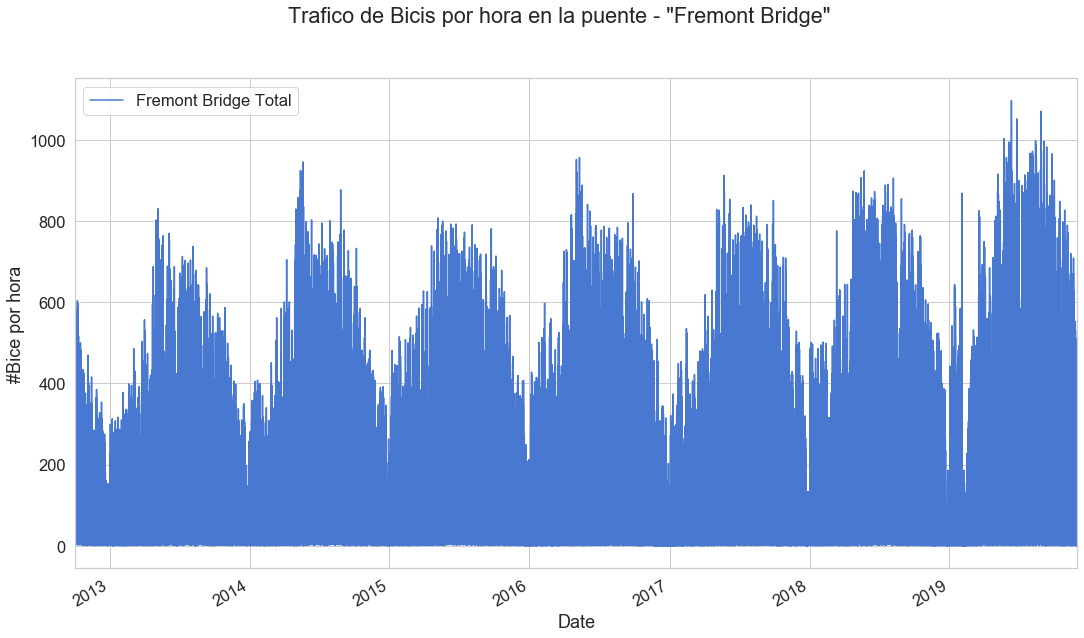

In [54]:
df['Fremont Bridge Total'].plot(style=['-'],figsize=(16,10), legend=True);
plt.suptitle('Trafico de Bicis por hora en la puente - "Fremont Bridge"');
plt.ylabel('#Bice por hora');

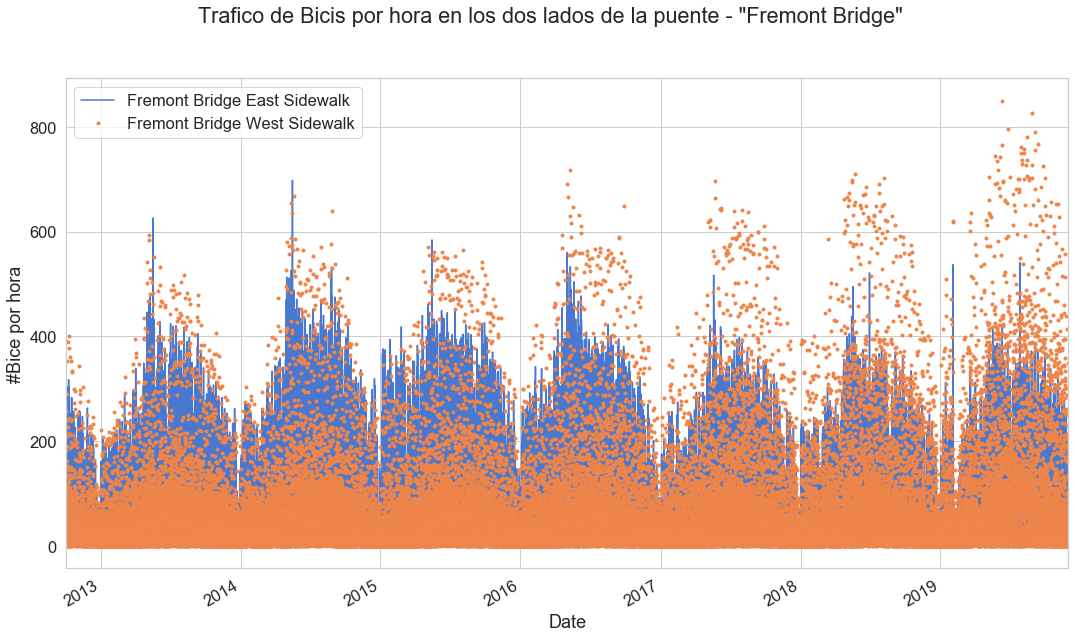

In [52]:
df[['Fremont Bridge East Sidewalk',
    'Fremont Bridge West Sidewalk']].plot(style=['-', '.'],
                                          figsize=(16, 10),
                                          legend=True)
plt.suptitle('Trafico de Bicis por hora en los dos lados de la puente - "Fremont Bridge"')
plt.ylabel('#Bice por hora');

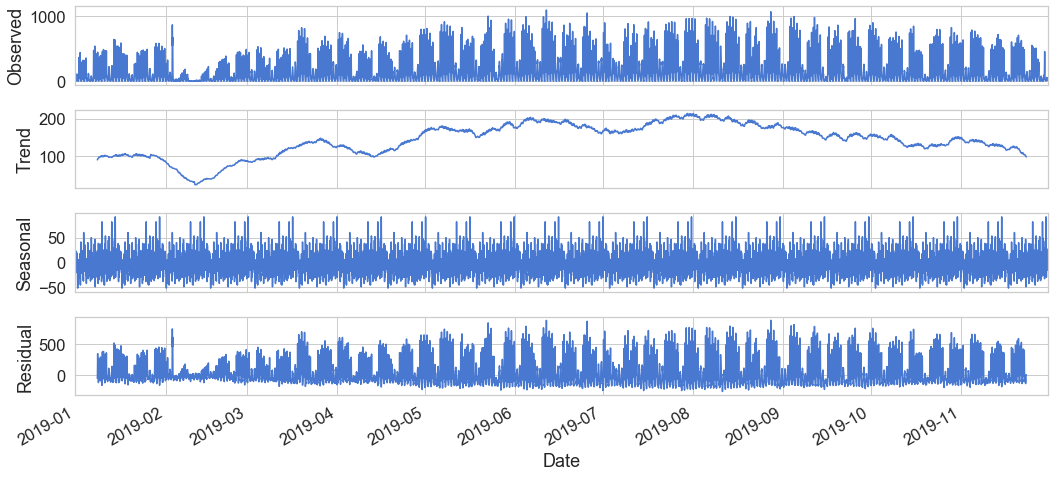

In [36]:
decomp_data(df['Fremont Bridge Total']['2019':].iloc[:])

### Definir set entrenameinto/validación

In [62]:
# Usar como data, los datos totales diarios de lo trafego de bicis (los dos lados de la puente)
data = df.resample('D').sum()
data = data[['Fremont Bridge Total']]
data.columns = ['Total']
data.head(2)

Total
Date              
2012-10-03  3521.0
2012-10-04  3475.0

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2615 entries, 2012-10-03 to 2019-11-30
Freq: D
Data columns (total 1 columns):
Total    2615 non-null float64
dtypes: float64(1)
memory usage: 40.9 KB


In [91]:
INICIO = '2013' # Treinamiento desde 2013
ENTREN = '2018' # Treinamineto hasta 2018
VALID = '2019' # Test desde enero 2019

In [92]:
set_entrenamiento = data[INICIO:ENTREN].iloc[:]
set_validacion = data[VALID:].iloc[:]

In [93]:
set_entrenamiento.head(2)

Total
Date              
2013-01-01   678.0
2013-01-02  1835.0

In [94]:
set_validacion.head(2)

Total
Date              
2019-01-01   687.0
2019-01-02  2393.0

In [95]:
set_validacion.tail(2)

Total
Date              
2019-11-29  1857.0
2019-11-30   628.0

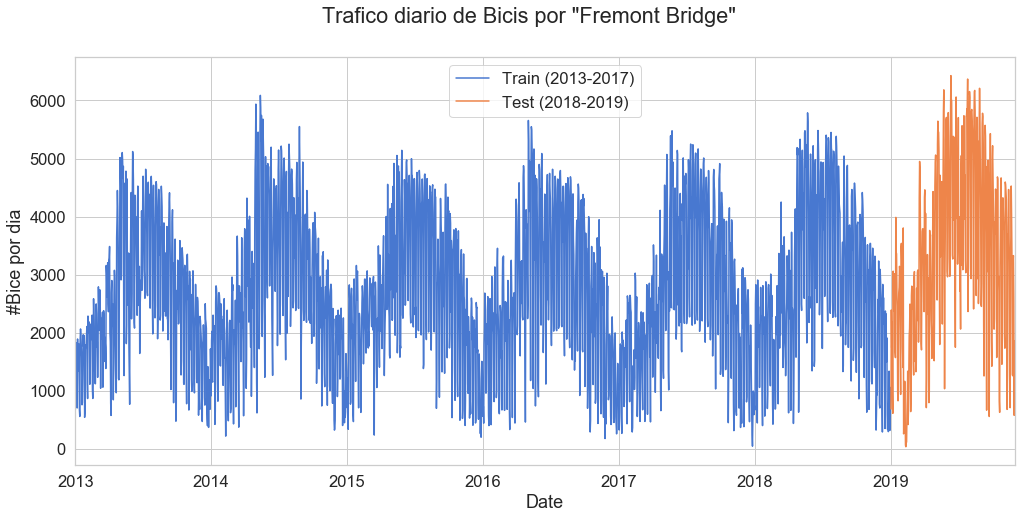

In [96]:
set_entrenamiento['Total'].plot(legend=True)
set_validacion['Total'].plot(legend=True)
plt.legend(['Train (2013-2017)', 'Test (2018-2019)']);
plt.suptitle('Trafico diario de Bicis por "Fremont Bridge"')
plt.ylabel('#Bice por dia');

### Normalización del set de entrenamiento

In [97]:
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [98]:
set_entrenamiento_escalado

array([[0.10430464],
       [0.29586093],
       [0.29056291],
       ...,
       [0.04486755],
       [0.11589404],
       [0.16738411]])

La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento

In [99]:
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Red LSTM
- Número de unidades en la capa oculta (na) = 50
- Dimension de entrada: 60
- dimension de salida: 1

In [100]:
X_train.shape[1]

60

In [253]:
int(len(set_entrenamiento)/(2*(X_train.shape[1]+1)))

17

In [101]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50
epochs = 30
batch_size = 32

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [102]:
history = modelo.fit(X_train,
                     Y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     verbose=0)

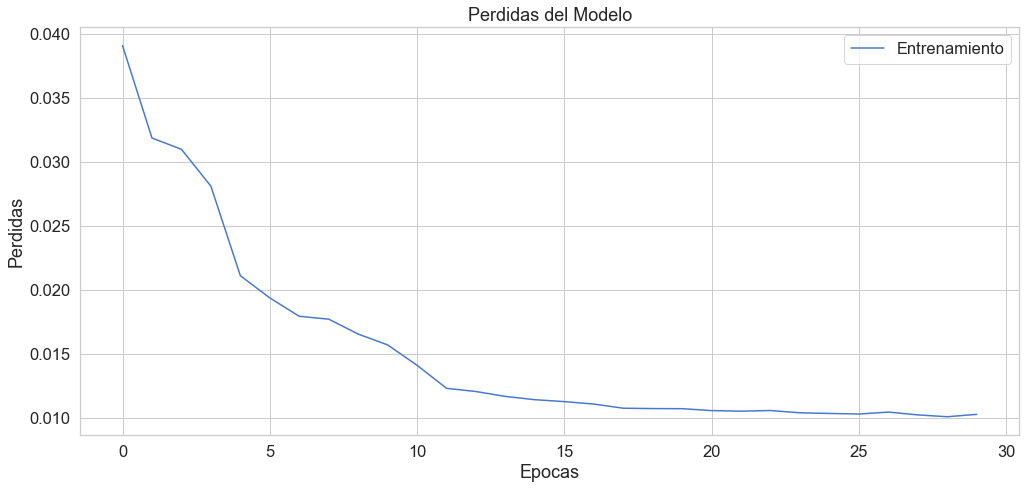

In [103]:
plt.plot(history.history['loss'])
plt.title('Perdidas del Modelo')
plt.ylabel('Perdidas')
plt.xlabel('Epocas')
plt.legend(['Entrenamiento'])
plt.show()

## Validación (predicción del valor de las acciones)

In [104]:
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

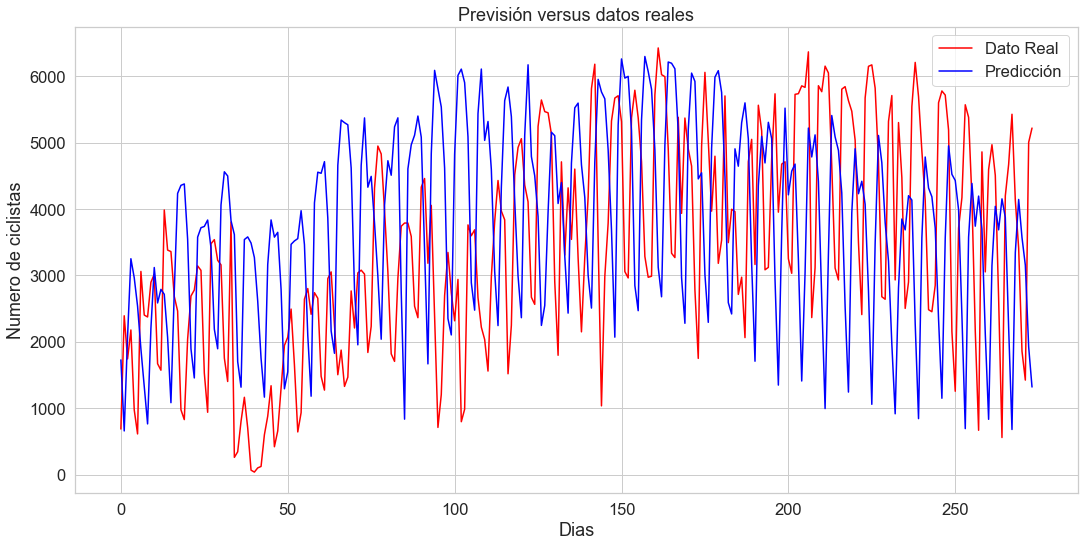

In [119]:
# Graficar resultados
graficar_predicciones(set_validacion.values, prediccion)

In [110]:
len(set_validacion.values)

334

In [113]:
set_validacion.values[:10]

array([[ 687.],
       [2393.],
       [1743.],
       [2179.],
       [ 975.],
       [ 613.],
       [3061.],
       [2404.],
       [2375.],
       [2898.]])

In [114]:
prediccion[:10]

array([[1728.1102],
       [ 658.0592],
       [2078.469 ],
       [3252.5447],
       [2965.4727],
       [2537.6697],
       [1894.4542],
       [1321.7775],
       [ 764.0328],
       [2204.2524]], dtype=float32)

In [112]:
len(prediccion)

274

In [117]:
rmse = np.sqrt(mean_squared_error(set_validacion.values[:len(prediccion)], prediccion))
print ('RMSE = {:,}'.format(round(rmse, 0)) )

RMSE =2,302.0


## Funciones para Benchmark 

In [160]:
def create_train_data(data, time_step, INICIO, ENTREN, VALID):
    set_entrenamiento = data[INICIO:ENTREN].iloc[:]
    set_validacion = data[VALID:].iloc[:]
    sc = MinMaxScaler(feature_range=(0,1))
    set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

    X_train = []
    Y_train = []
    m = len(set_entrenamiento_escalado)

    for i in range(time_step,m):
        X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
        Y_train.append(set_entrenamiento_escalado[i,0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    x_test = set_validacion.values
    x_test = sc.transform(x_test)

    X_test = []
    for i in range(time_step,len(x_test)):
        X_test.append(x_test[i-time_step:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    
    return X_train, Y_train, X_test, set_validacion, sc

In [161]:
def create_model(X_train, na, epochs, batch_size, dropout, optimizer, loss):  
    dim_entrada = (X_train.shape[1],1)
    dim_salida = 1

    modelo = Sequential()
    modelo.add(LSTM(units=na, input_shape=dim_entrada, dropout=dropout))
    modelo.add(Dense(units=dim_salida))
    modelo.compile(optimizer=optimizer, loss=loss)
    modelo.summary()
    return modelo

In [171]:
def fit_model (modelo, X_train, Y_train, epochs, batch_size, verbose):
    history = modelo.fit(X_train, Y_train,epochs,batch_size,verbose, shuffle=False)
    plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.title('Perdidas del Modelo')
    plt.ylabel('Perdidas')
    plt.xlabel('Epocas')
    plt.legend(['Entrenamiento'])
    plt.show()
    return history

In [163]:
def predict(modelo, X_test, set_validacion, sc, tickers):
    prediccion = modelo.predict(X_test)
    prediccion = sc.inverse_transform(prediccion)
    graficar_predicciones(set_validacion.values, prediccion, tickers)
    return prediccion

In [188]:
def test_model(data,
               time_step,
               INICIO,
               ENTREN,
               VALID,
               na,
               epochs,
               batch_size,
               dropout,
               optimizer,
               loss,
               title='Previsión versus datos reales',
               verbose=0):
    X_train, Y_train, X_test, set_validacion, sc = create_train_data(
        data, time_step, INICIO, ENTREN, VALID)
    modelo = create_model(X_train, na, epochs, batch_size, dropout, optimizer, loss)
    history = fit_model(modelo,
                        X_train,
                        Y_train,
                        epochs,
                        batch_size,
                        verbose=verbose)
    prediccion = predict(modelo, X_test, set_validacion, sc, title)
    real = set_validacion.values[:len(prediccion)]
    rmse = round(np.sqrt(mean_squared_error(real, prediccion)), 0)
    print ('RMSE = {:,}'.format(rmse))
    return prediccion, real, rmse

### Test Funciones

In [189]:
result = []

In [190]:
data = data

INICIO = '2013' # Treinamiento desde enero 2013
ENTREN = '2018' # Treinamineto hasta deciembre 2018
VALID = '2019' # Test desde enero 2019

time_step = 60
na = 50
epochs = 30
batch_size = 32
dropout=0.0
optimizer='rmsprop'
loss='mse'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


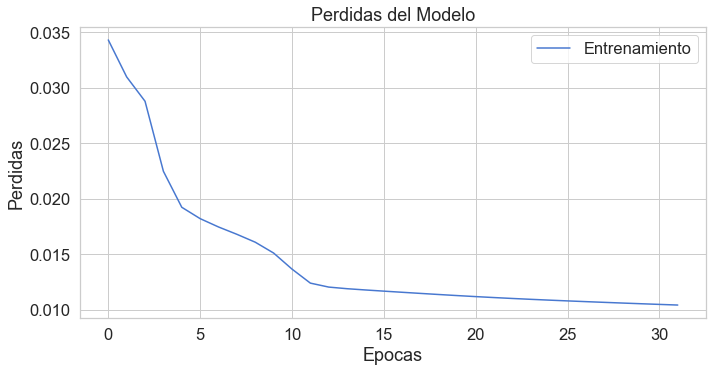

RMSE = 2,191.0


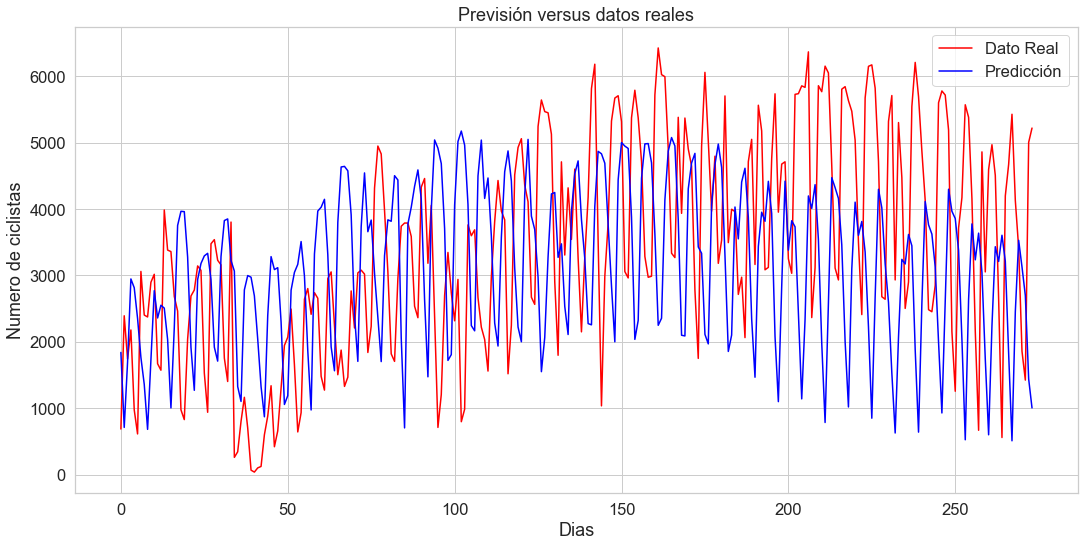

In [191]:
prediccion, real, rmse = test_model(data, time_step, INICIO, ENTREN, VALID, na,
                                    epochs, batch_size, dropout, optimizer,
                                    loss)

test = [time_step, na, epochs, batch_size, dropout, optimizer, loss,
              rmse]
result.append(test)

In [192]:
result

[[60, 50, 30, 32, 0.0, 'rmsprop', 'mse', 2191.0]]

## Benchmark

### Repetir con mas epocas

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


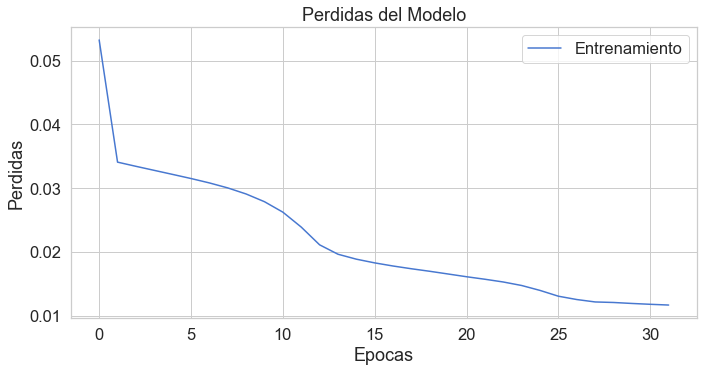

RMSE = 2,084.0


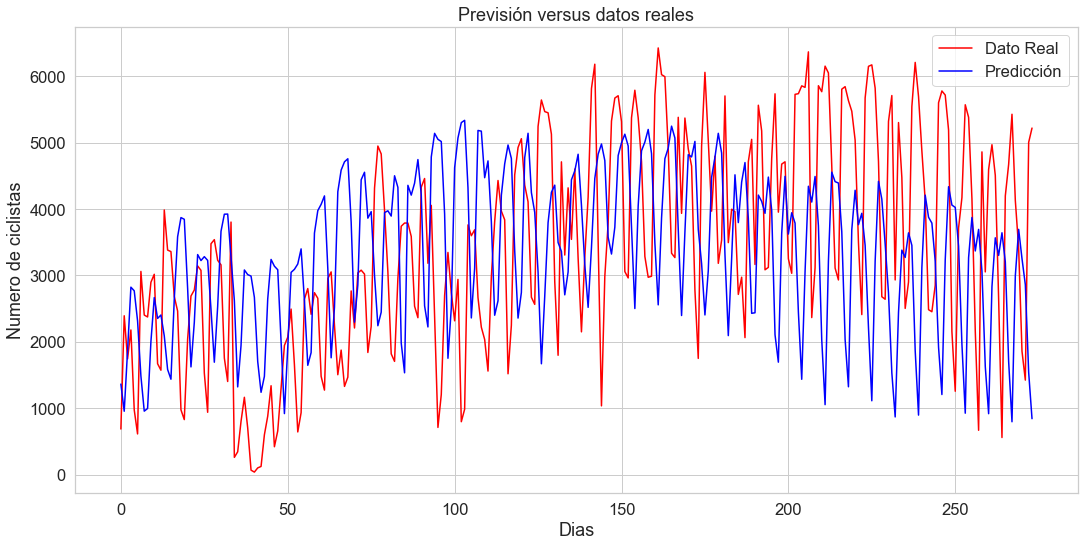

In [193]:
epochs = 100
prediccion, real, rmse = test_model(data, time_step, INICIO, ENTREN, VALID, na,
                                    epochs, batch_size, dropout, optimizer,
                                    loss)

test = [time_step, na, epochs, batch_size, dropout, optimizer, loss,
              rmse]
result.append(test)

In [194]:
result

[[60, 50, 30, 32, 0.0, 'rmsprop', 'mse', 2191.0],
 [60, 50, 100, 32, 0.0, 'rmsprop', 'mse', 2084.0]]

### Adicionando Dropout

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


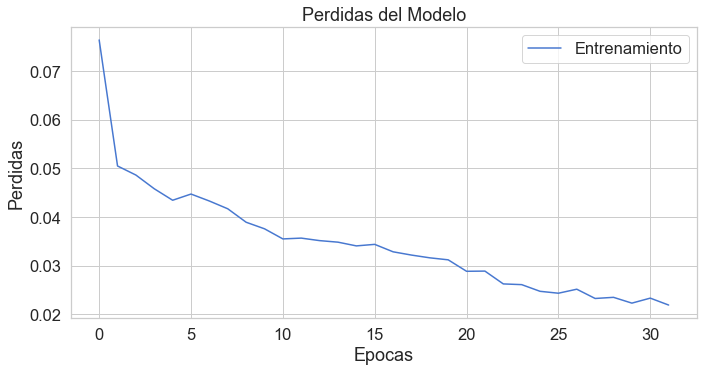

RMSE = 2,219.0


[[60, 50, 30, 32, 0.0, 'rmsprop', 'mse', 2191.0],
 [60, 50, 100, 32, 0.0, 'rmsprop', 'mse', 2084.0],
 [60, 50, 100, 32, 0.2, 'rmsprop', 'mse', 2219.0]]

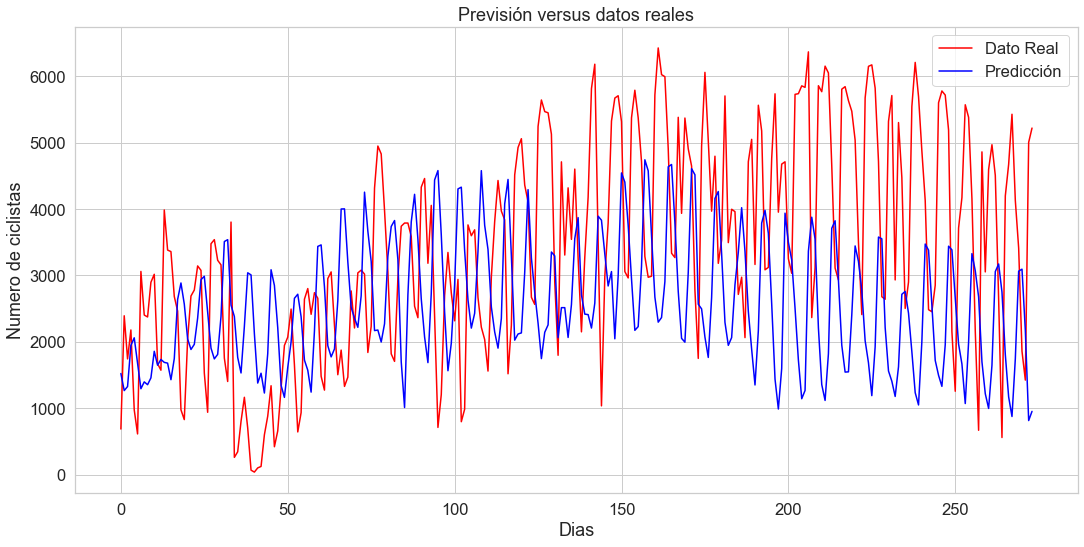

In [195]:
dropout=0.2
prediccion, real, rmse = test_model(data, time_step, INICIO, ENTREN, VALID, na,
                                    epochs, batch_size, dropout, optimizer,
                                    loss)

test = [time_step, na, epochs, batch_size, dropout, optimizer, loss,
              rmse]
result.append(test)
result

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


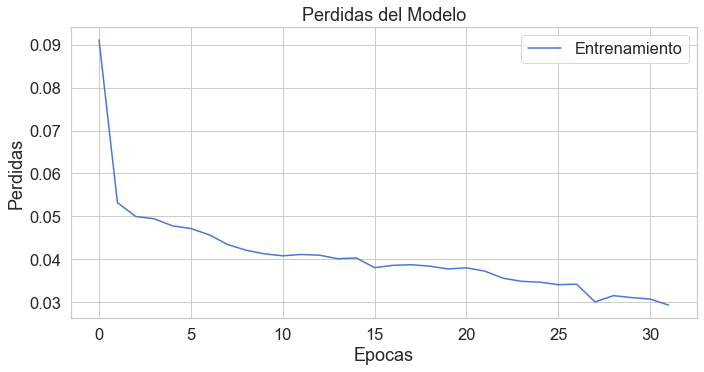

RMSE = 2,306.0


[[60, 50, 30, 32, 0.0, 'rmsprop', 'mse', 2191.0],
 [60, 50, 100, 32, 0.0, 'rmsprop', 'mse', 2084.0],
 [60, 50, 100, 32, 0.2, 'rmsprop', 'mse', 2219.0],
 [60, 50, 100, 32, 0.4, 'rmsprop', 'mse', 2306.0]]

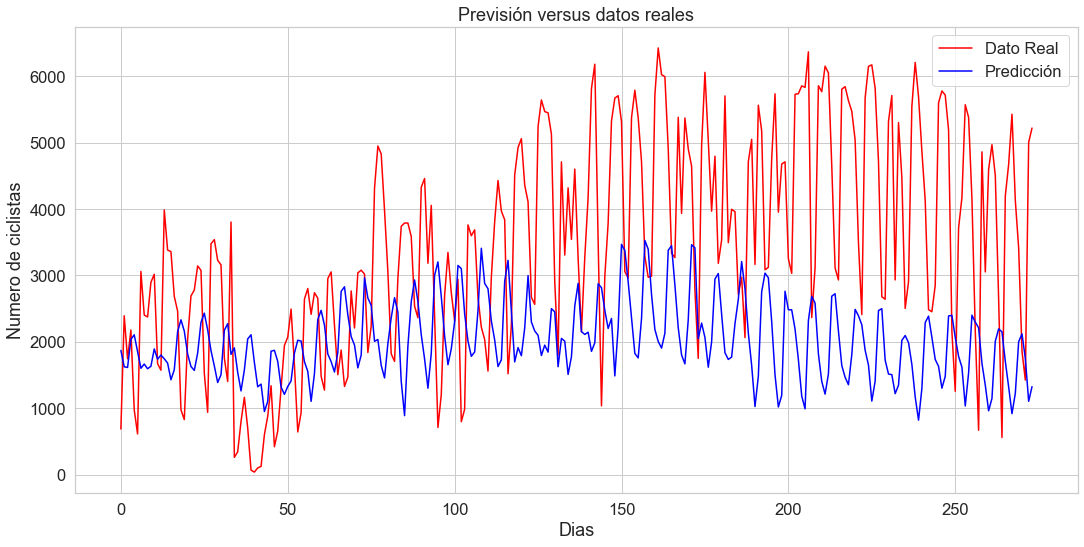

In [196]:
dropout=0.4
prediccion, real, rmse = test_model(data, time_step, INICIO, ENTREN, VALID, na,
                                    epochs, batch_size, dropout, optimizer,
                                    loss)

test = [time_step, na, epochs, batch_size, dropout, optimizer, loss,
              rmse]
result.append(test)
result

### Cambiando número de neuronas (na) de la capa oculta

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


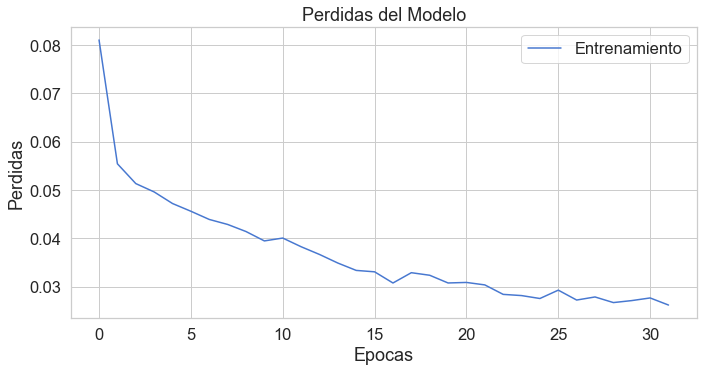

RMSE = 2,380.0


[[60, 50, 30, 32, 0.0, 'rmsprop', 'mse', 2191.0],
 [60, 50, 100, 32, 0.0, 'rmsprop', 'mse', 2084.0],
 [60, 50, 100, 32, 0.2, 'rmsprop', 'mse', 2219.0],
 [60, 50, 100, 32, 0.4, 'rmsprop', 'mse', 2306.0],
 [60, 100, 100, 32, 0.4, 'rmsprop', 'mse', 2380.0]]

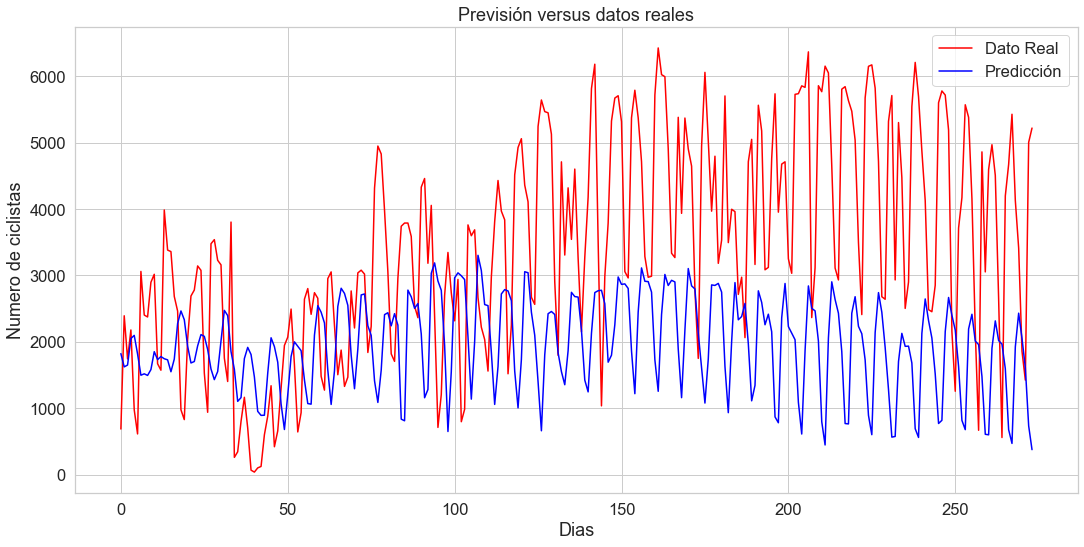

In [197]:
na = 100
prediccion, real, rmse = test_model(data, time_step, INICIO, ENTREN, VALID, na,
                                    epochs, batch_size, dropout, optimizer,
                                    loss)

test = [time_step, na, epochs, batch_size, dropout, optimizer, loss,
              rmse]
result.append(test)
result

### Test con 'Adam'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


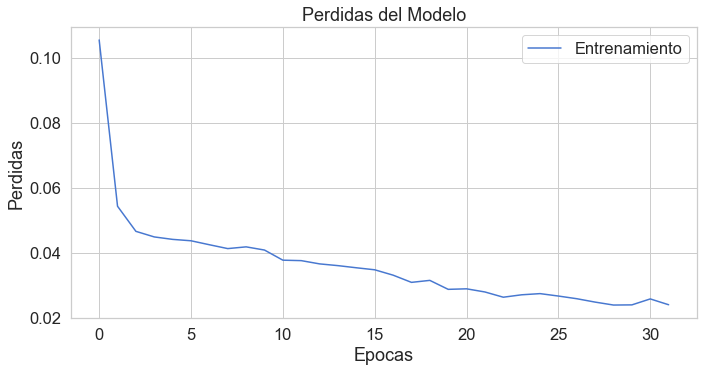

RMSE = 2,445.0


[[60, 50, 30, 32, 0.0, 'rmsprop', 'mse', 2191.0],
 [60, 50, 100, 32, 0.0, 'rmsprop', 'mse', 2084.0],
 [60, 50, 100, 32, 0.2, 'rmsprop', 'mse', 2219.0],
 [60, 50, 100, 32, 0.4, 'rmsprop', 'mse', 2306.0],
 [60, 100, 100, 32, 0.4, 'rmsprop', 'mse', 2380.0],
 [60, 100, 100, 32, 0.4, 'adam', 'mse', 2445.0]]

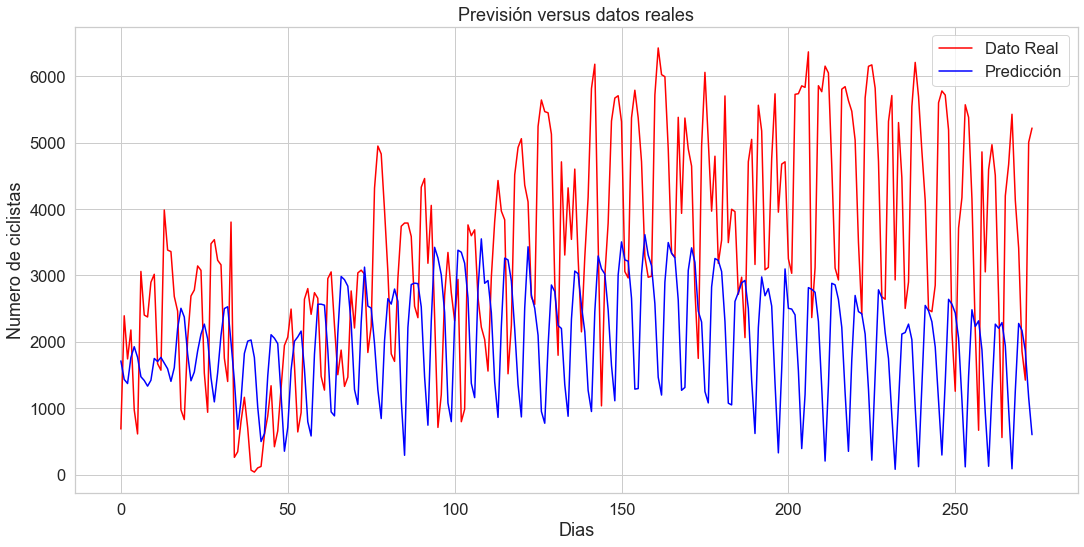

In [198]:
optimizer='adam'
na = 100
epochs = 100
dropout=0.4

prediccion, real, rmse = test_model(data, time_step, INICIO, ENTREN, VALID, na,
                                    epochs, batch_size, dropout, optimizer,
                                    loss)

test = [time_step, na, epochs, batch_size, dropout, optimizer, loss,
              rmse]
result.append(test)
result

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


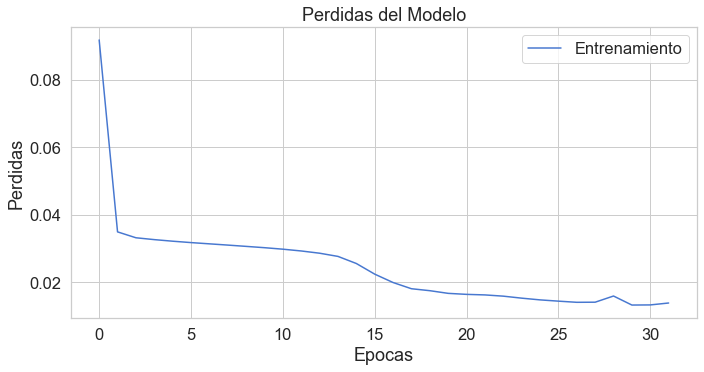

RMSE = 2,075.0


[[60, 50, 30, 32, 0.0, 'rmsprop', 'mse', 2191.0],
 [60, 50, 100, 32, 0.0, 'rmsprop', 'mse', 2084.0],
 [60, 50, 100, 32, 0.2, 'rmsprop', 'mse', 2219.0],
 [60, 50, 100, 32, 0.4, 'rmsprop', 'mse', 2306.0],
 [60, 100, 100, 32, 0.4, 'rmsprop', 'mse', 2380.0],
 [60, 100, 100, 32, 0.4, 'adam', 'mse', 2445.0],
 [60, 100, 100, 32, 0.0, 'adam', 'mse', 2075.0]]

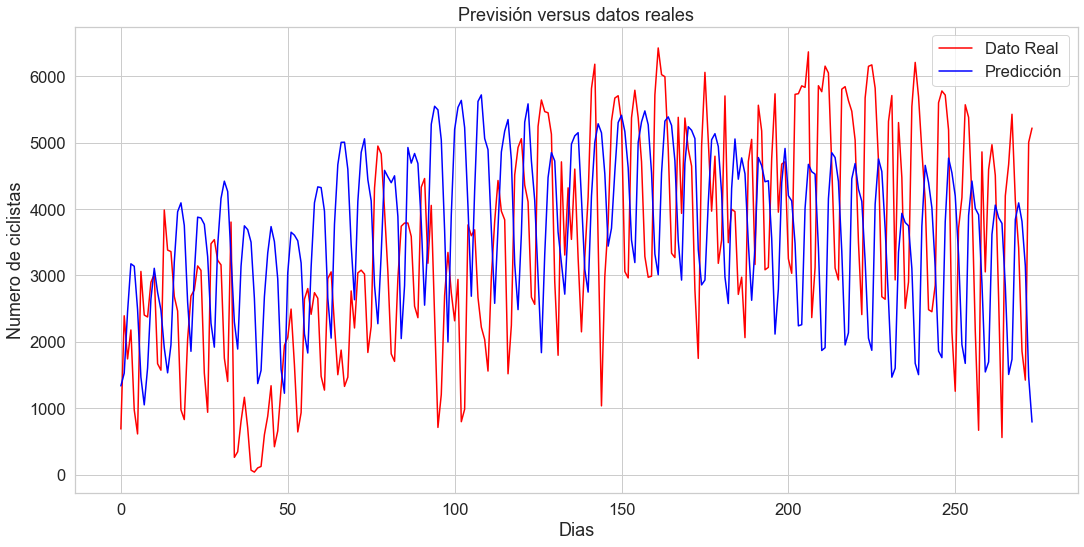

In [199]:
optimizer='adam'
na = 100
epochs = 100
dropout=0.0

prediccion, real, rmse = test_model(data, time_step, INICIO, ENTREN, VALID, na,
                                    epochs, batch_size, dropout, optimizer,
                                    loss)

test = [time_step, na, epochs, batch_size, dropout, optimizer, loss,
              rmse]
result.append(test)
result

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


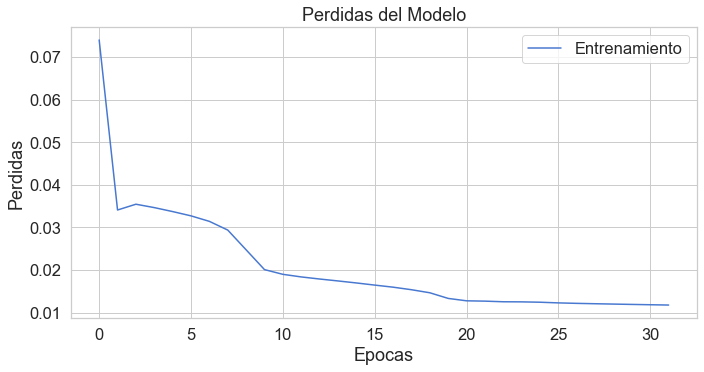

RMSE = 2,047.0


[[60, 50, 30, 32, 0.0, 'rmsprop', 'mse', 2191.0],
 [60, 50, 100, 32, 0.0, 'rmsprop', 'mse', 2084.0],
 [60, 50, 100, 32, 0.2, 'rmsprop', 'mse', 2219.0],
 [60, 50, 100, 32, 0.4, 'rmsprop', 'mse', 2306.0],
 [60, 100, 100, 32, 0.4, 'rmsprop', 'mse', 2380.0],
 [60, 100, 100, 32, 0.4, 'adam', 'mse', 2445.0],
 [60, 100, 100, 32, 0.0, 'adam', 'mse', 2075.0],
 [60, 100, 100, 32, 0.0, 'rmsprop', 'mse', 2047.0]]

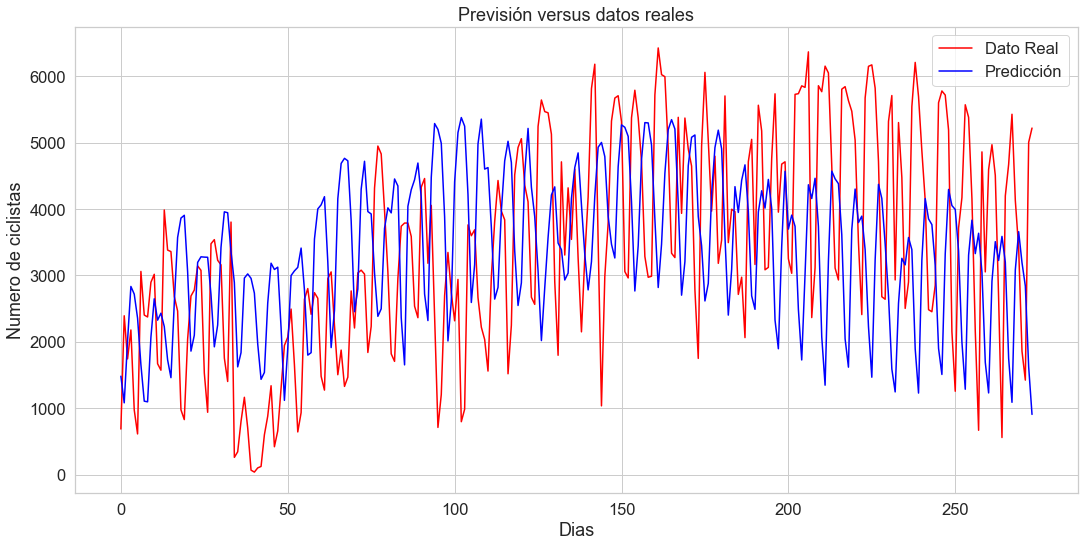

In [200]:
optimizer='rmsprop'
na = 100
epochs = 100
dropout=0.0

prediccion, real, rmse = test_model(data, time_step, INICIO, ENTREN, VALID, na,
                                    epochs, batch_size, dropout, optimizer,
                                    loss)

test = [time_step, na, epochs, batch_size, dropout, optimizer, loss,
              rmse]
result.append(test)
result

### Reducindo la ventana a 30 dias

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


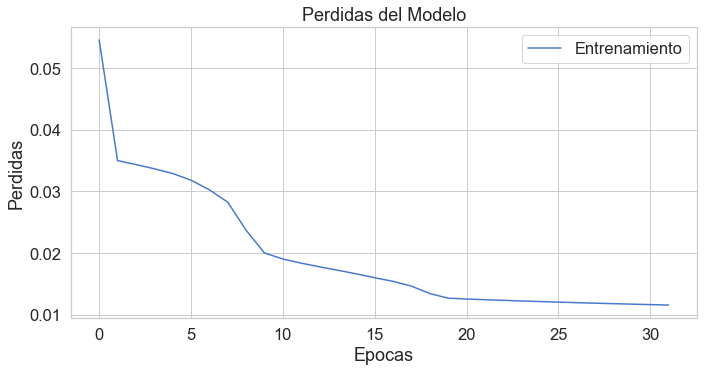

RMSE = 1,826.0


[[60, 50, 30, 32, 0.0, 'rmsprop', 'mse', 2191.0],
 [60, 50, 100, 32, 0.0, 'rmsprop', 'mse', 2084.0],
 [60, 50, 100, 32, 0.2, 'rmsprop', 'mse', 2219.0],
 [60, 50, 100, 32, 0.4, 'rmsprop', 'mse', 2306.0],
 [60, 100, 100, 32, 0.4, 'rmsprop', 'mse', 2380.0],
 [60, 100, 100, 32, 0.4, 'adam', 'mse', 2445.0],
 [60, 100, 100, 32, 0.0, 'adam', 'mse', 2075.0],
 [60, 100, 100, 32, 0.0, 'rmsprop', 'mse', 2047.0],
 [30, 100, 100, 32, 0.0, 'rmsprop', 'mse', 1826.0]]

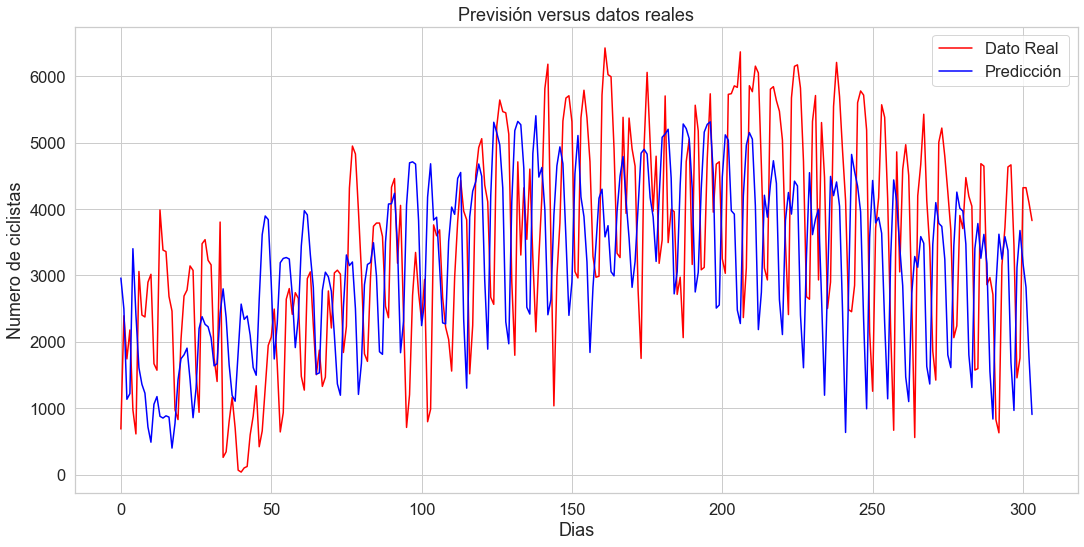

In [201]:
time_step = 30
optimizer='rmsprop'
na = 100
epochs = 100
dropout=0.0

prediccion, real, rmse = test_model(data, time_step, INICIO, ENTREN, VALID, na,
                                    epochs, batch_size, dropout, optimizer,
                                    loss)

test = [time_step, na, epochs, batch_size, dropout, optimizer, loss,
              rmse]
result.append(test)
result

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


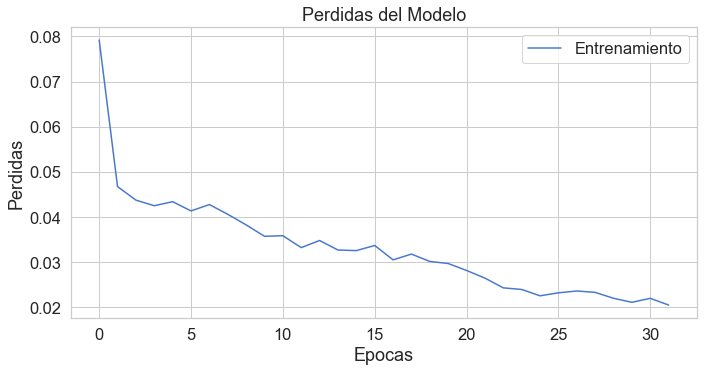

RMSE = 1,865.0


[[60, 50, 30, 32, 0.0, 'rmsprop', 'mse', 2191.0],
 [60, 50, 100, 32, 0.0, 'rmsprop', 'mse', 2084.0],
 [60, 50, 100, 32, 0.2, 'rmsprop', 'mse', 2219.0],
 [60, 50, 100, 32, 0.4, 'rmsprop', 'mse', 2306.0],
 [60, 100, 100, 32, 0.4, 'rmsprop', 'mse', 2380.0],
 [60, 100, 100, 32, 0.4, 'adam', 'mse', 2445.0],
 [60, 100, 100, 32, 0.0, 'adam', 'mse', 2075.0],
 [60, 100, 100, 32, 0.0, 'rmsprop', 'mse', 2047.0],
 [30, 100, 100, 32, 0.0, 'rmsprop', 'mse', 1826.0],
 [30, 100, 200, 32, 0.1, 'rmsprop', 'mse', 1865.0]]

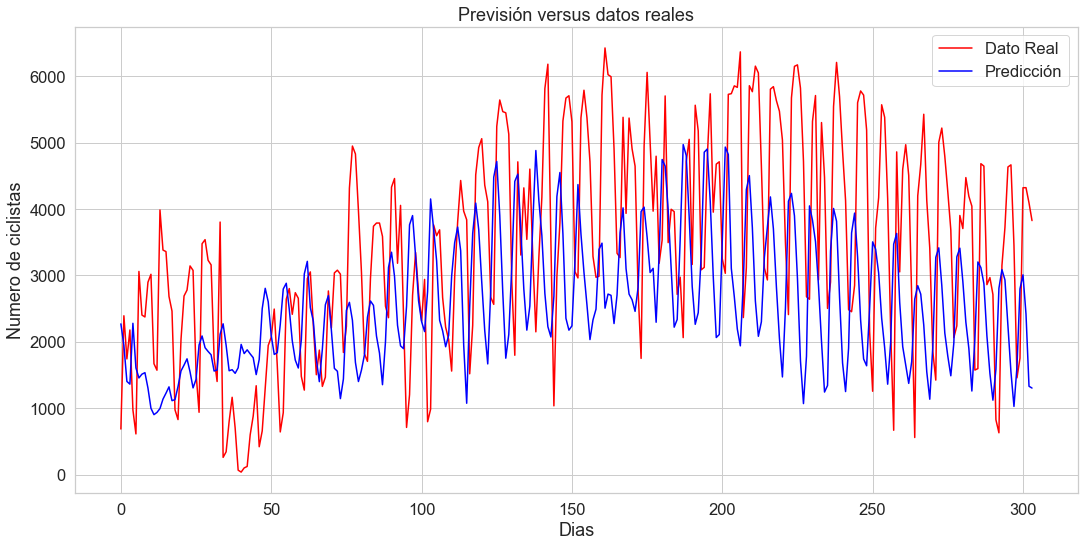

In [202]:
time_step = 30
optimizer='rmsprop'
na = 100
epochs = 200
dropout=0.1

prediccion, real, rmse = test_model(data, time_step, INICIO, ENTREN, VALID, na,
                                    epochs, batch_size, dropout, optimizer,
                                    loss)

test = [time_step, na, epochs, batch_size, dropout, optimizer, loss,
              rmse]
result.append(test)
result

Mejor resultado fue un RMSE de 1,826.0 para los parametros abajo:

In [205]:
time_step = 30
optimizer='rmsprop'
na = 100
epochs = 100
dropout=0.0

In [ ]:
df_result = pd.DataFrame(result,
                         columns=[
                             'time_step', 'na', 'epochs', 'batch_size',
                             'dropout', 'optimizer', 'loss', 'rmse'
                         ])

In [249]:
df_result.sort_values(by=['rmse'])

time_step   na  epochs  batch_size  dropout optimizer loss    rmse
8         30  100     100          32      0.0   rmsprop  mse  1826.0
9         30  100     200          32      0.1   rmsprop  mse  1865.0
7         60  100     100          32      0.0   rmsprop  mse  2047.0
6         60  100     100          32      0.0      adam  mse  2075.0
1         60   50     100          32      0.0   rmsprop  mse  2084.0
0         60   50      30          32      0.0   rmsprop  mse  2191.0
2         60   50     100          32      0.2   rmsprop  mse  2219.0
3         60   50     100          32      0.4   rmsprop  mse  2306.0
4         60  100     100          32      0.4   rmsprop  mse  2380.0
5         60  100     100          32      0.4      adam  mse  2445.0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


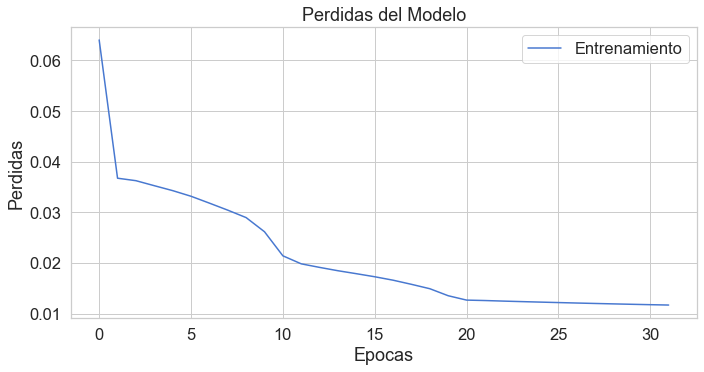

RMSE = 1,843.0


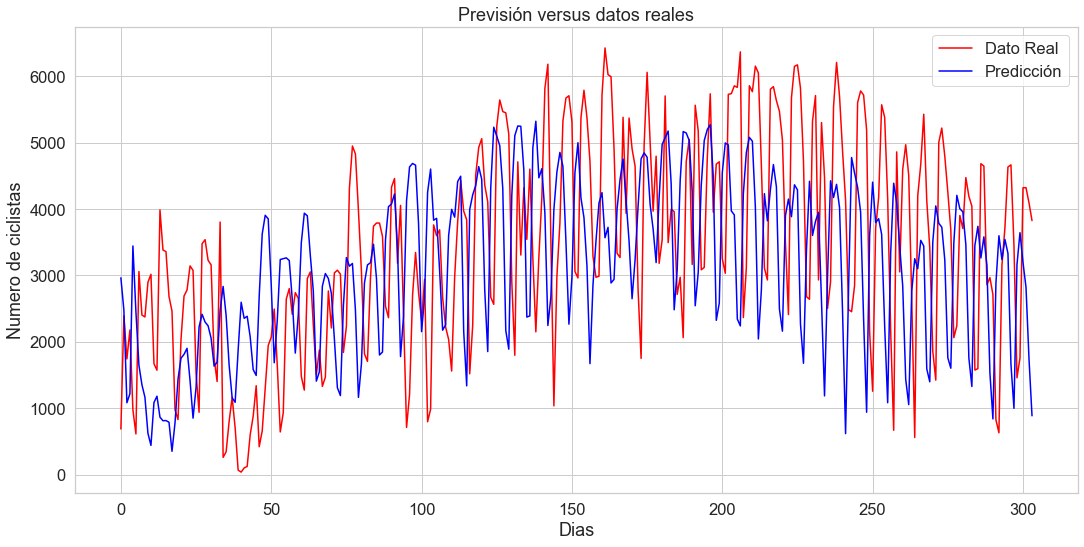

In [206]:
prediccion, real, rmse = test_model(data, time_step, INICIO, ENTREN, VALID, na,
                                    epochs, batch_size, dropout, optimizer,
                                    loss)

## Test con Prophet

In [207]:
set_entrenamiento = data[INICIO:ENTREN].iloc[:]

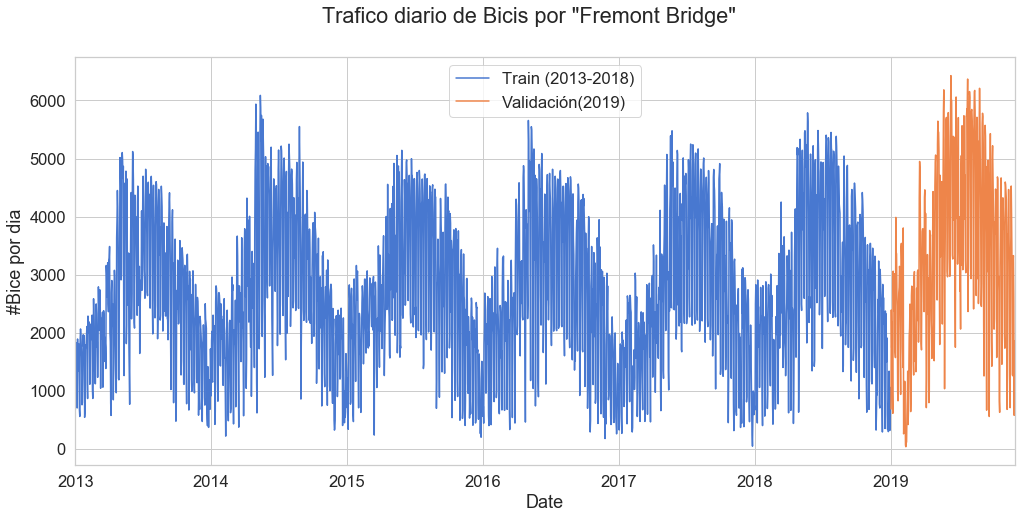

In [209]:
set_entrenamiento['Total'].plot(legend=True)
set_validacion['Total'].plot(legend=True)
plt.legend(['Train (2013-2018)', 'Validación(2019)']);
plt.suptitle('Trafico diario de Bicis por "Fremont Bridge"')
plt.ylabel('#Bice por dia');

In [210]:
len(real) # tamano de los datos de validación (2019)

304

In [211]:
frequency = 'd'
prediction_size = 304
boxCoxApply = True

In [212]:
df_pf = set_entrenamiento.reset_index()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/mjrovai/anaconda3/envs/python_3_7/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



R2 = 0.78
MSE = 382122.15
RMSE = 618.16
MAE = 477.14
MAPE = 26.59


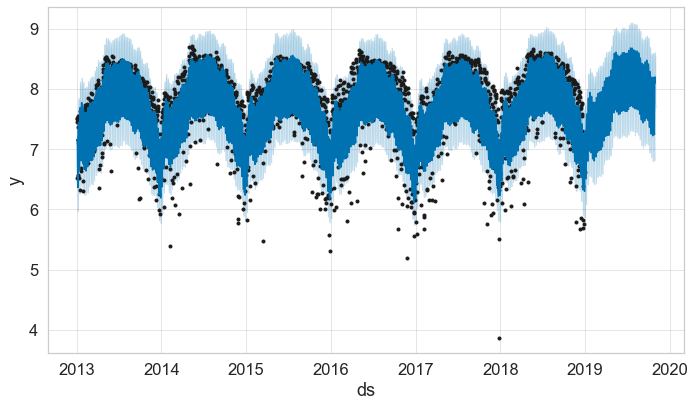

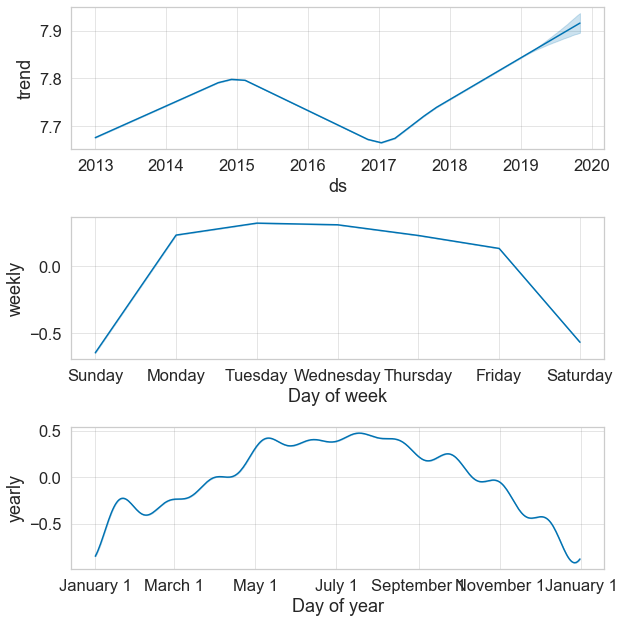

In [213]:
df_pf.columns = ['ds', 'y']
if boxCoxApply: 
    df_pf['y'] = boxcox(df_pf['y'], 0)
m = Prophet()
m.fit(df_pf)
future = m.make_future_dataframe(periods=prediction_size, freq=frequency)
forecast = m.predict(future)
m.plot(forecast);
m.plot_components(forecast);
if boxCoxApply:
    forecast[['yhat']] = inv_boxcox(forecast['yhat'], 0)
    df_pf[['y']] = inv_boxcox(df_pf['y'], 0)

metric_prophet(df_pf, forecast);

In [236]:
prophet_fc = forecast[['ds','yhat']].set_index('ds')
prophet_fc = prophet_fc[prophet_fc.index >= '2019-01-01']
prophet_fc = prophet_fc.reset_index()
prophet_fc.columns = ['Date', 'Total']

In [219]:
len(prophet_fc)

304

In [237]:
proph = prophet_fc.Total.values

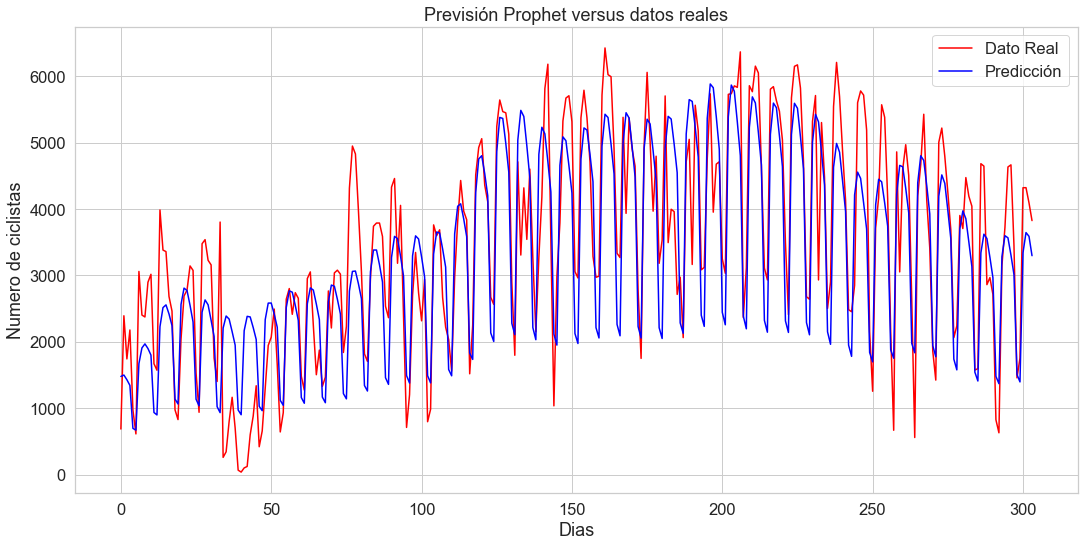

In [238]:
graficar_predicciones(real, proph, titulo='Previsión Prophet versus datos reales')

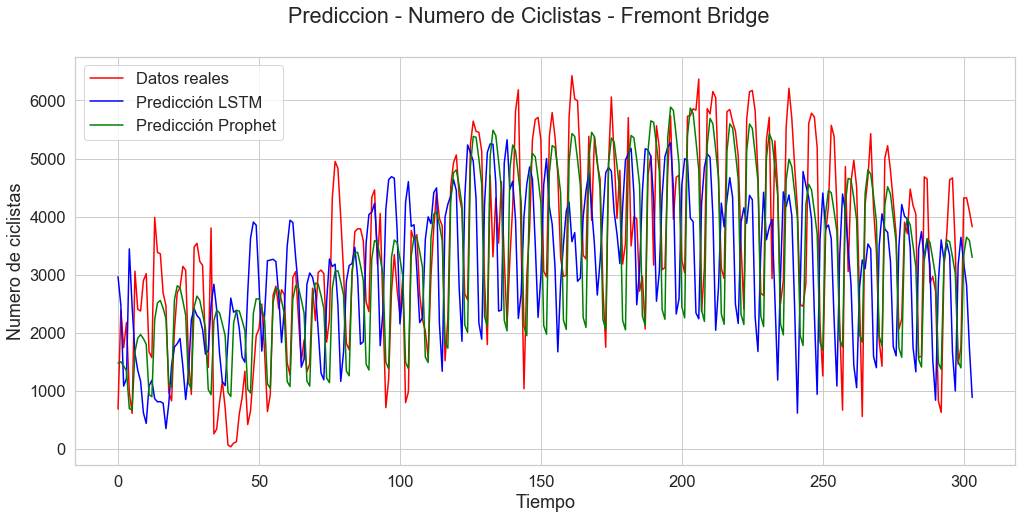

In [242]:
plt.plot(real, color='red', label='Datos reales')
plt.plot(prediccion, color='blue', label='Predicción LSTM')
plt.plot(proph, color='green', label='Predicción Prophet')
plt.xlabel('Tiempo')
plt.ylabel('Numero de ciclistas')
plt.legend()
plt.suptitle('Prediccion - Numero de Ciclistas - Fremont Bridge');

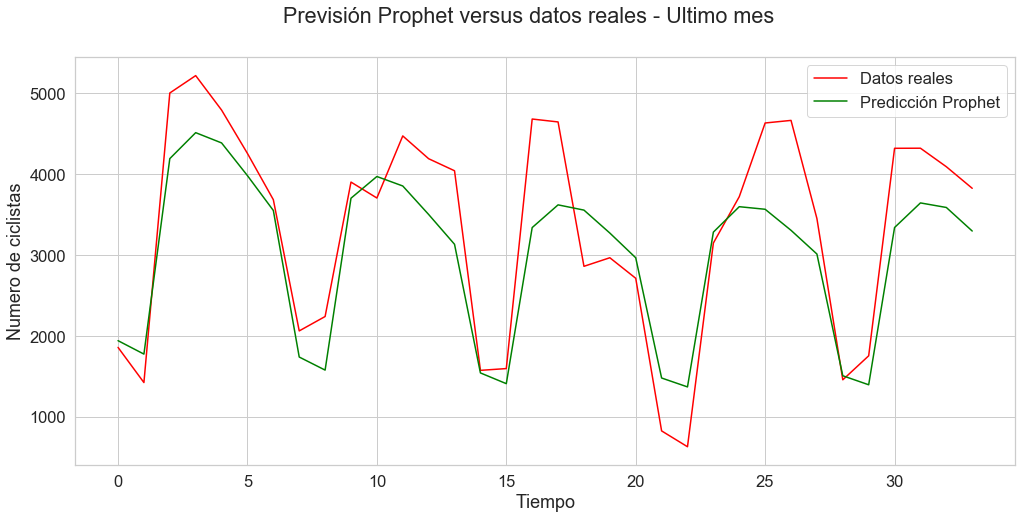

In [239]:
plt.plot(real[270:], color='red', label='Datos reales')
plt.plot(proph[270:], color='green', label='Predicción Prophet')
plt.xlabel('Tiempo')
plt.ylabel('Numero de ciclistas')
plt.legend()
plt.suptitle('Previsión Prophet versus datos reales - Ultimo mes');

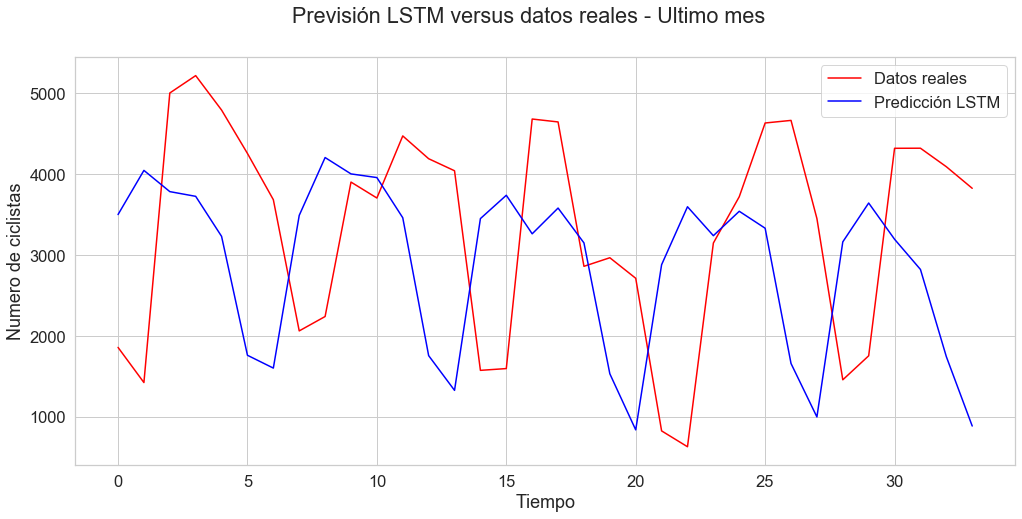

In [240]:
plt.plot(real[270:], color='red', label='Datos reales')
plt.plot(prediccion[270:], color='blue', label='Predicción LSTM')
plt.xlabel('Tiempo')
plt.ylabel('Numero de ciclistas')
plt.legend()
plt.suptitle('Previsión LSTM versus datos reales - Ultimo mes');

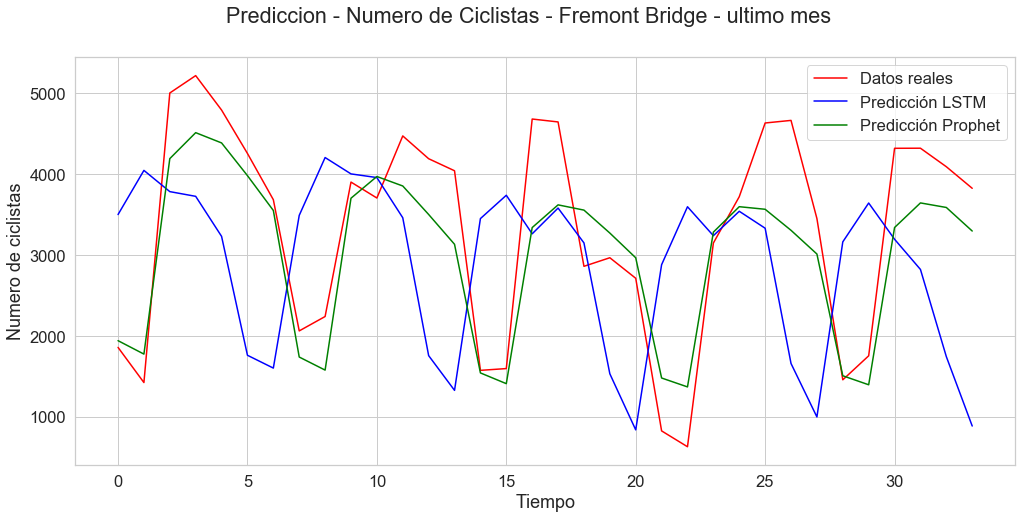

In [244]:
plt.plot(real[270:], color='red', label='Datos reales')
plt.plot(prediccion[270:], color='blue', label='Predicción LSTM')
plt.plot(proph[270:], color='green', label='Predicción Prophet')
plt.xlabel('Tiempo')
plt.ylabel('Numero de ciclistas')
plt.legend()
plt.suptitle('Prediccion - Numero de Ciclistas - Fremont Bridge - ultimo mes');